In [1]:
!pip install sastrawi

In [2]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [5]:
stop_words = set(stopwords.words("indonesian"))
def bersihkan_teks(teks):
    teks = teks.lower()
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r"http\S+|www\S+|https\S+", "", teks, flags=re.MULTILINE)
    teks = re.sub(r"@\w+|#", "", teks)
    teks = re.sub(r"[^\w\s]", "", teks)
    teks = re.sub(r'<.*?>', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    tokens = " ".join([stemmer.stem(word) for word in teks.split() if word not in stop_words])
    return tokens

In [6]:
csv_file = "dataset_pengaduan.csv"

In [7]:
df = pd.read_csv(csv_file)

In [8]:
print(df.columns)

Index(['ID', 'date', 'kategori', 'pengaduan', 'sentimen', 'jumlah_pengaduan'], dtype='object')


In [9]:
df['konten'] = df['pengaduan'].apply(bersihkan_teks)
df.drop(columns=['pengaduan'], inplace=True)

In [10]:
df_classification = df[['date', 'konten', 'kategori', 'sentimen']]
df_classification.head()

,date,konten,kategori,sentimen
0,1980-01-01,macet parah area parkir pintu masuk,Transportasi,negatif
1,1980-01-02,kualitas ajar turun pustaka pustaka guru profe...,Pendidikan,positif
2,1980-01-03,fasilitas sekolah manajemen buruk minim ruang ...,Pendidikan,negatif
3,1980-01-04,sedia obat darurat cukup menit pasien,Kesehatan,positif
4,1980-01-05,jadwal bus menit lambat tumpang pagi,Transportasi,netral


In [11]:
def build_vocab(texts, max_words=10000):
    all_tokens = [token for text in texts for token in text]
    token_counts = Counter(all_tokens)
    most_common = token_counts.most_common(max_words - 2)  # -2 untuk <pad> dan <unk>
    vocab = {'<pad>': 0, '<unk>': 1}
    for i, (token, _) in enumerate(most_common, 2):
        vocab[token] = i
    return vocab

In [12]:
df_train, df_val = train_test_split(df_classification, test_size=0.2, random_state=42)

In [13]:
vocab = build_vocab(df_classification['konten'])

In [14]:
def text_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

In [15]:
ohe = OneHotEncoder()
kategori_train = ohe.fit_transform(df_train[['kategori']]).toarray()
kategori_val = ohe.transform(df_val[['kategori']]).toarray()

In [16]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_val['date'] = pd.to_datetime(df_val['date'])

date_features_train = np.array([
    df_train['date'].dt.year,
    df_train['date'].dt.month,
    df_train['date'].dt.day,
    df_train['date'].dt.weekday
]).T

date_features_val = np.array([
    df_val['date'].dt.year,
    df_val['date'].dt.month,
    df_val['date'].dt.day,
    df_val['date'].dt.weekday
]).T

In [17]:
scaler = MinMaxScaler()
date_features_train_scaled = scaler.fit_transform(date_features_train)
date_features_val_scaled = scaler.transform(date_features_val)

In [18]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['sentimen'])
y_val = label_encoder.transform(df_val['sentimen'])

In [19]:
class SentimentDataset(Dataset):
    def __init__(self, df, vocab, kategori, date_features, labels, max_len=100):
        self.texts = df['konten'].values
        self.kategori = kategori
        self.date_features = date_features
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        indices = text_to_indices(text, self.vocab)
        indices = indices[:self.max_len] + [self.vocab['<pad>']] * (self.max_len - len(indices)) if len(indices) < self.max_len else indices[:self.max_len]
        return {
            'text': torch.tensor(indices, dtype=torch.long),
            'kategori': torch.tensor(self.kategori[idx], dtype=torch.float),
            'date_features': torch.tensor(self.date_features[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [20]:
max_len = 100
train_dataset = SentimentDataset(df_train, vocab, kategori_train, date_features_train_scaled, y_train, max_len)
val_dataset = SentimentDataset(df_val, vocab, kategori_val, date_features_val_scaled, y_val, max_len)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [22]:
accelerator = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, num_kategori=10, num_date=4, hidden_dim=256, num_classes=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc_lstm = nn.Linear(hidden_dim * 2, 128)
        self.fc_additional = nn.Linear(num_kategori + num_date, 64)
        self.fc = nn.Sequential(
            nn.Linear(128 + 64, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, inputs):
        text, kategori, date_features = inputs
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        lstm_out = self.fc_lstm(context)
        additional = torch.cat((kategori, date_features), dim=1)
        additional = self.fc_additional(additional)
        combined = torch.cat((lstm_out, additional), dim=1)
        out = self.fc(combined)
        return out

In [24]:
model = LSTMModel(
    vocab_size=len(vocab),
    embedding_dim=300,
    num_kategori=kategori_train.shape[1],
    num_date=date_features_train_scaled.shape[1],
    hidden_dim=256,
    num_classes=3
).to(accelerator)

In [25]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_val),
    y=y_val
)
class_weight_dict = dict(enumerate(class_weights))

In [26]:
print(class_weight_dict)

{0: np.float64(0.682710360129715), 1: np.float64(1.5704750687082842), 2: np.float64(1.1129660545353366)}


# Training Model

In [27]:
class_weights= torch.FloatTensor(class_weights).to(accelerator)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [29]:
def training(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            texts = batch['text'].to(accelerator)
            kategori = batch['kategori'].to(accelerator)
            date_features = batch['date_features'].to(accelerator)
            labels = batch['label'].to(accelerator)

            optimizer.zero_grad()
            outputs = model((texts, kategori, date_features))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validasi
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(accelerator)
                kategori = batch['kategori'].to(accelerator)
                date_features = batch['date_features'].to(accelerator)
                labels = batch['label'].to(accelerator)

                outputs = model((texts, kategori, date_features))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, train_accs, val_losses, val_accs

In [30]:
train_losses, train_accs, val_losses, val_accs = training(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50
)

Epoch [1/50], Train Loss: 1.0408, Train Acc: 49.33%, Val Loss: 1.0414, Val Acc: 48.83%
Epoch [2/50], Train Loss: 1.0387, Train Acc: 49.36%, Val Loss: 1.0411, Val Acc: 48.83%
Epoch [3/50], Train Loss: 1.0389, Train Acc: 49.36%, Val Loss: 1.0402, Val Acc: 48.83%
Epoch [4/50], Train Loss: 1.0387, Train Acc: 49.36%, Val Loss: 1.0421, Val Acc: 48.83%
Epoch [5/50], Train Loss: 1.0378, Train Acc: 49.36%, Val Loss: 1.0404, Val Acc: 48.83%
Epoch [6/50], Train Loss: 1.0375, Train Acc: 49.36%, Val Loss: 1.0406, Val Acc: 48.83%
Epoch [7/50], Train Loss: 1.0372, Train Acc: 49.36%, Val Loss: 1.0410, Val Acc: 48.83%
Epoch [8/50], Train Loss: 1.0373, Train Acc: 49.36%, Val Loss: 1.0418, Val Acc: 48.83%
Early stopping triggered.


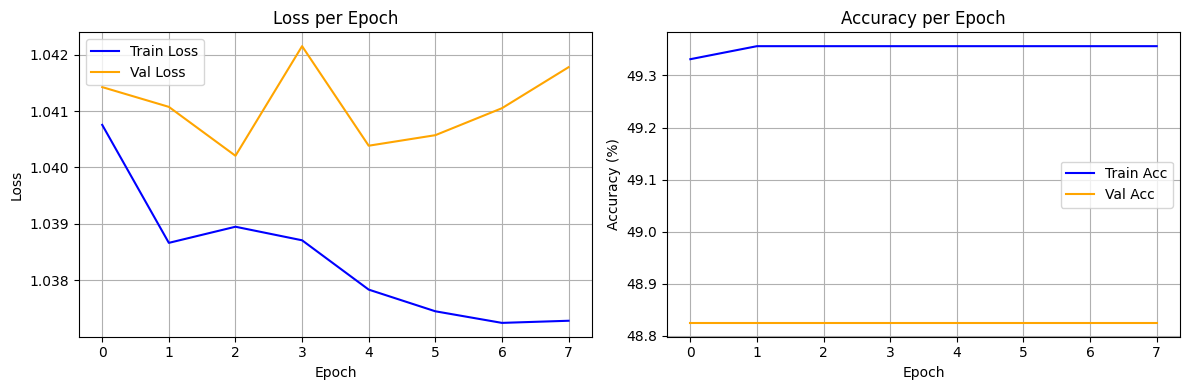

In [31]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='blue')
    plt.plot(val_accs, label='Val Acc', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, train_accs, val_losses, val_accs)